In [35]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


### İmported Library

In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline 
#parameters tuning
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss,f1_score,precision_score,recall_score
import optuna
import xgboost as xgb
from sklearn import metrics
import gc

import os

pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=50

from tqdm import tqdm,tqdm_notebook
tqdm.pandas(desc='my bar')

import warnings 
warnings.filterwarnings('ignore')

import sys
sys.setrecursionlimit(10000)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

cm = sns.light_palette("red", as_cmap=True)


/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/sample_submission.csv
/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/train.csv
/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/test.csv


> **Some specific function to facilitate feature engineering process**

In [37]:
def null_rate(df):
    return (df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:'null_rate'}).sort_values('null_rate',ascending=False).style.background_gradient(cmap=cm)

# ----------------------------------------------------------------------------------------------------

def decline_object(features,train,valid,test,q):
    if isinstance(features,str):
        features=[features]
    else :
        pass
    for feature in features:
        train[feature]=train[feature].astype(object)
        valid[feature]=valid[feature].astype(object)
        test[feature]=test[feature].astype(object)

        treshold=train[feature].value_counts().reindex(train[feature].unique(), fill_value=0).quantile(q)
        object_list=train[feature].value_counts().reindex(train[feature].unique(), fill_value=0).loc[lambda x: x>treshold].index

        train.loc[~train[feature].isin(object_list),feature]='unknown'
        valid.loc[~valid[feature].isin(object_list),feature]='unknown'
        test.loc[~test[feature].isin(object_list),feature]='unknown'

        train[feature]=train[feature].astype('category')
        valid[feature]=valid[feature].astype('category')
        test[feature]=test[feature].astype('category')
        
    return train,valid,test
# ----------------------------------------------------------------------------------------------------

def label_data(feature,data,le_fit=None):
    if type(feature)==str:
        feature=[feature]
    else :
        pass
    for col in feature:
        le=LabelEncoder()
        le_fit.update({col:le.fit(data[col])})
        data[col]=le.transform(data[col])
    return data[feature],le_fit


## Introduction

<!-- # Features
# ![image.png](attachment:192c266e-b2c8-41f2-8dfb-bcd69e8799b1.png)!) -->

In [38]:
train_df=pd.read_csv('/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/train.csv')
train_df.columns=train_df.columns.str.lower() 
test_df=pd.read_csv('/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/test.csv')
test_df.columns=test_df.columns.str.lower() 


In [39]:
train_df

,target,cst_nr,cc_nr,day_of_month,day_of_week,txn_time,txn_source,txn_trm,txn_entry,txn_amnt,city,country,mc_name,mc_id,mcc_code
0,0.0,c64007916f81cb9543a6aacc768a15d5eefde44318b3c0...,bf4e876751b8785159aad106b055123b6cdda8a9591d5f...,8.0,4.0,1800.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,540.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,09adaccd88433a530071a5c7437e3d03c4a3eefae1bbcc...,e0d92b0729b1406983f91eaf8600b24236a53d88e32efa...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...
1,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,11.0,7.0,1404.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,49490.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,0b0b39198d9a5f47e27f7ee20aded3e0d4f29ba3c8dfdf...,2b047d7167ac6b27522c339cff056ac613730477cc511c...,3c7ce134e41449a3fbe18892efdf90304e12e052ae35a2...
2,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,194024f4b029f8df4e045ad034588ef6fc1957d39ab3d5...,17.0,6.0,1750.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,5040.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,59c94e8a976c930a684743605363d473e929b2d265b6d3...,2ff0f25b15cabe373de08aa40c1adb2796b59cbecd31ae...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...
3,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,194024f4b029f8df4e045ad034588ef6fc1957d39ab3d5...,1.0,4.0,1741.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,10.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,a7db20b1dba321830a2e7abdebda548a117b20caf75be8...,e60354c25c84c774233d2c5290eb669b3f60604d71ac3e...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...
4,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,7.0,3.0,2344.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,47760.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,0b0b39198d9a5f47e27f7ee20aded3e0d4f29ba3c8dfdf...,2b047d7167ac6b27522c339cff056ac613730477cc511c...,3c7ce134e41449a3fbe18892efdf90304e12e052ae35a2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607502,0.0,7be05c0f24b82c9c870aa46b109f89efe129fbd3974d38...,ea7e1b9c068ea1aec5ef6dad5f7aa3820384cb8a519427...,4.0,7.0,924.0,M,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,60.0,7e943c4295cfab64ebe6d2cbe98bc5514e17d6e2dee038...,18ea71c60d9b0fa64274e50b983f7b8515f7a0971395f4...,113d0832a20a53132badd510b00d75cf2c0c9ba9b91987...,fed9060efb4531d7f506eae84390d22973749db155cef9...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...
607503,0.0,7be05c0f24b82c9c870aa46b109f89efe129fbd3974d38...,ea7e1b9c068ea1aec5ef6dad5f7aa3820384cb8a519427...,2.0,5.0,2124.0,M,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,60.0,7e943c4295cfab64ebe6d2cbe98bc5514e17d6e2dee038...,18ea71c60d9b0fa64274e50b983f7b8515f7a0971395f4...,113d0832a20a53132badd510b00d75cf2c0c9ba9b91987...,fed9060efb4531d7f506eae84390d22973749db155cef9...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...
607504,0.0,7be05c0f24b82c9c870aa46b109f89efe129fbd3974d38...,ea7e1b9c068ea1aec5ef6dad5f7aa3820384cb8a519427...,1.0,4.0,2123.0,M,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,60.0,7e943c4295cfab64ebe6d2cbe98bc5514e17d6e2dee038...,18ea71c60d9b0fa64274e50b983f7b8515f7a0971395f4...,113d0832a20a53132badd510b00d75cf2c0c9ba9b91987...,fed9060efb4531d7f506eae84390d22973749db155cef9...,03a76869

In [40]:
test_df

,id,cst_nr,cc_nr,day_of_month,day_of_week,txn_time,txn_source,txn_trm,txn_entry,txn_amnt,city,country,mc_name,mc_id,mcc_code
0,0,c64007916f81cb9543a6aacc768a15d5eefde44318b3c0...,bf4e876751b8785159aad106b055123b6cdda8a9591d5f...,27.0,2.0,1900.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,1900.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,a1f0edc5bea9f23f4f92e0d66a74741bd1ade1370ddd46...,8f18d68c2b2300ba1c6b560eedbb3e7feb4a97ca2249ef...,9c5ab283ab8a30e71a94b80bbf81c6459b998d9233c845...
1,1,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,194024f4b029f8df4e045ad034588ef6fc1957d39ab3d5...,28.0,3.0,1110.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,80.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,0642d5cb0918532d41bd94fabacc0064c2ee8131924335...,bedff7d1dae20eadfac484fe0a43f7c7aaccaf4e4f6c5f...,9b509123dc98501d21939de143413e6505e546eccedbcb...
2,2,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,21.0,3.0,1732.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,2730.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,59c94e8a976c930a684743605363d473e929b2d265b6d3...,2ff0f25b15cabe373de08aa40c1adb2796b59cbecd31ae...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...
3,3,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,21.0,3.0,211.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,9680.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,0b0b39198d9a5f47e27f7ee20aded3e0d4f29ba3c8dfdf...,2b047d7167ac6b27522c339cff056ac613730477cc511c...,3c7ce134e41449a3fbe18892efdf90304e12e052ae35a2...
4,4,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,21.0,3.0,202.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,1740.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,9a8a06b47dd1f21464c9434b2b958f703149c481ca0481...,d0894721cf911689257dd1b574793a6ca7cffe229f0bad...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326227,326227,d044568959f4185f154cdd2162287c64f55380846ebb42...,d2c58c43f4bcc0b954cf6b247690ffafc64f5a77254760...,26.0,1.0,1731.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,130.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
326228,326228,d044568959f4185f154cdd2162287c64f55380846ebb42...,d2c58c43f4bcc0b954cf6b247690ffafc64f5a77254760...,25.0,7.0,1811.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,100.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,b05949fdd838ee81c6531153fec635819d979a42152f62...,e70ff83862a39c3d9f7c891c14d9ee0f2841bdbd7670ea...,77b669500ba0d0667610fd2768553b9cf7f6c874808124...
326229,326229,d044568959f4185f154cdd2162287c64f55380846ebb42...,d2c58c43f4bcc0b954cf6b247690ffafc64f5a77254760...,28.0,3.0,1522.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,60.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9

In [41]:
train_df.info()
print('\n\n\n')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607507 entries, 0 to 607506
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   target        607507 non-null  float64
 1   cst_nr        607507 non-null  object 
 2   cc_nr         607507 non-null  object 
 3   day_of_month  607507 non-null  float64
 4   day_of_week   607507 non-null  float64
 5   txn_time      607507 non-null  float64
 6   txn_source    607507 non-null  object 
 7   txn_trm       607507 non-null  object 
 8   txn_entry     607507 non-null  object 
 9   txn_amnt      607507 non-null  float64
 10  city          607507 non-null  object 
 11  country       607507 non-null  object 
 12  mc_name       607507 non-null  object 
 13  mc_id         607507 non-null  object 
 14  mcc_code      607507 non-null  object 
dtypes: float64(5), object(10)
memory usage: 69.5+ MB




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326232 entries, 0 to 326231
Data 

## Data preprocessing 

In [42]:
data_all=pd.concat([train_df,test_df],axis=0)
data_all=data_all.reset_index(drop=True)
data_all.target=data_all.target.astype('O')
data_all.drop(data_all.txn_source[data_all.txn_source=='R'].index,inplace=True)
data_all.drop('id',inplace=True,axis=1)
data_all.drop(['txn_trm'],axis=1,inplace=True) #all values same
data_all

,target,cst_nr,cc_nr,day_of_month,day_of_week,txn_time,txn_source,txn_entry,txn_amnt,city,country,mc_name,mc_id,mcc_code
0,0.0,c64007916f81cb9543a6aacc768a15d5eefde44318b3c0...,bf4e876751b8785159aad106b055123b6cdda8a9591d5f...,8.0,4.0,1800.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,540.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,09adaccd88433a530071a5c7437e3d03c4a3eefae1bbcc...,e0d92b0729b1406983f91eaf8600b24236a53d88e32efa...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...
1,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,11.0,7.0,1404.0,O,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,49490.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,0b0b39198d9a5f47e27f7ee20aded3e0d4f29ba3c8dfdf...,2b047d7167ac6b27522c339cff056ac613730477cc511c...,3c7ce134e41449a3fbe18892efdf90304e12e052ae35a2...
2,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,194024f4b029f8df4e045ad034588ef6fc1957d39ab3d5...,17.0,6.0,1750.0,O,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,5040.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,59c94e8a976c930a684743605363d473e929b2d265b6d3...,2ff0f25b15cabe373de08aa40c1adb2796b59cbecd31ae...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...
3,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,194024f4b029f8df4e045ad034588ef6fc1957d39ab3d5...,1.0,4.0,1741.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,10.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,a7db20b1dba321830a2e7abdebda548a117b20caf75be8...,e60354c25c84c774233d2c5290eb669b3f60604d71ac3e...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...
4,0.0,24882e5a50d43c050f71ffdfc0061550a8bf5e6eb0911c...,933c28d9d4c6fb6db04a2209f34def95497ea3060f581b...,7.0,3.0,2344.0,O,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,47760.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,0b0b39198d9a5f47e27f7ee20aded3e0d4f29ba3c8dfdf...,2b047d7167ac6b27522c339cff056ac613730477cc511c...,3c7ce134e41449a3fbe18892efdf90304e12e052ae35a2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933734,NaN,d044568959f4185f154cdd2162287c64f55380846ebb42...,d2c58c43f4bcc0b954cf6b247690ffafc64f5a77254760...,26.0,1.0,1731.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,130.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
933735,NaN,d044568959f4185f154cdd2162287c64f55380846ebb42...,d2c58c43f4bcc0b954cf6b247690ffafc64f5a77254760...,25.0,7.0,1811.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,100.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,b05949fdd838ee81c6531153fec635819d979a42152f62...,e70ff83862a39c3d9f7c891c14d9ee0f2841bdbd7670ea...,77b669500ba0d0667610fd2768553b9cf7f6c874808124...
933736,NaN,d044568959f4185f154cdd2162287c64f55380846ebb42...,d2c58c43f4bcc0b954cf6b247690ffafc64f5a77254760...,28.0,3.0,1522.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,60.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
933737,NaN,084c9e32b0360529cbc3e7f5e7bdba45a428d05ca64b17...,4350da3e5a3b9d2db6660cd76dbaebd4cfa0d2c538255c...,28.0,3.0,1153.0,O,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,140.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,09adaccd88433a530071a5c7437e3d03c4a3eefae1bbcc...,e0d92b0729b1406983f91eaf8600b

In [43]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933738 entries, 0 to 933738
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   target        607506 non-null  object 
 1   cst_nr        933738 non-null  object 
 2   cc_nr         933738 non-null  object 
 3   day_of_month  933738 non-null  float64
 4   day_of_week   933738 non-null  float64
 5   txn_time      933738 non-null  float64
 6   txn_source    933738 non-null  object 
 7   txn_entry     933738 non-null  object 
 8   txn_amnt      933738 non-null  float64
 9   city          933738 non-null  object 
 10  country       933738 non-null  object 
 11  mc_name       933738 non-null  object 
 12  mc_id         933738 non-null  object 
 13  mcc_code      933738 non-null  object 
dtypes: float64(4), object(10)
memory usage: 106.9+ MB


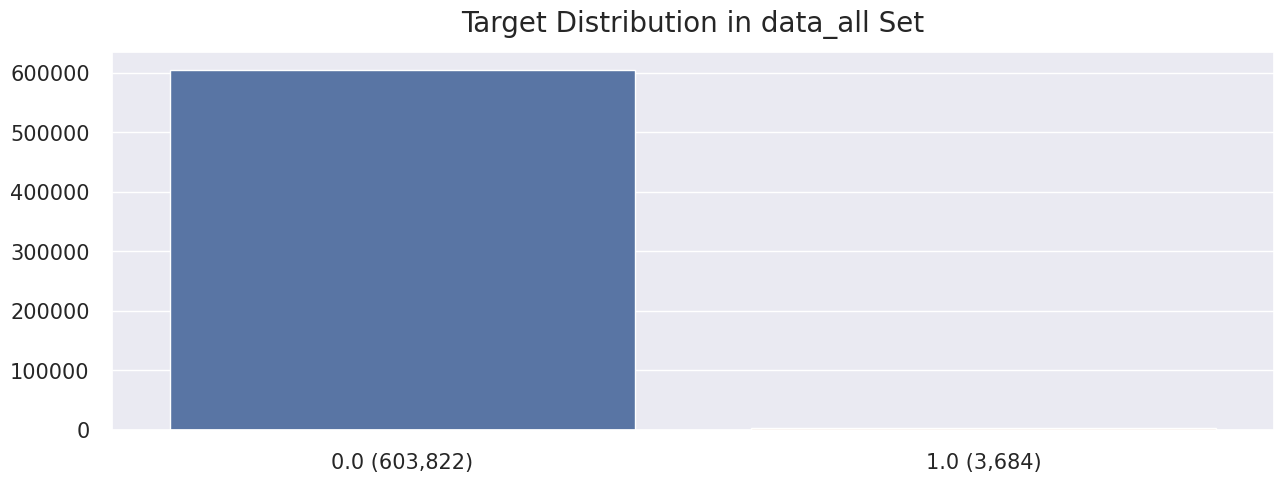

In [44]:
def visualize(data,feature):
    
    fig, ax = plt.subplots(figsize=(15, 5), dpi=100)

    sns.barplot(
        x=data[feature].value_counts().index,
        y=data[feature].value_counts().values,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([f'{x} ({value_count:,})' for value_count, x in zip(data[feature].value_counts().values, data[feature].value_counts().index)])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title('Target Distribution in data_all Set', size=20, pad=15)

    plt.show()


visualize(data_all,'target')

**ı have created a function(label_data) to make labels to categorical features
. I added to the list(le_list) that labelEncoder for inverse transform**

In [45]:
masked_features=['cst_nr','cc_nr','txn_entry','city','country','mc_name','mc_id','mcc_code']
cat_features=['cst_nr', 'cc_nr','txn_source', 'txn_trm', 'txn_entry','city', 'country','mc_name', 'mc_id', 'mcc_code']
numeric_features=[ 'txn_amnt']
time_features=['type', 'day_of_month', 'day_of_week']

le_list={}
data_all.loc[:,masked_features],le_list=label_data(masked_features,data_all,le_list)

In [46]:
# For txn_time feature some engineering ways
data_all.txn_time=data_all.txn_time.astype(str)
data_all.txn_time=data_all.txn_time.replace(0,'00:00')
data_all.txn_time=data_all.txn_time.str[:-2]
# I bring it to the appropriate form so that I can apply pd.datetime to the txn_time variable
data_all=pd.concat([data_all[data_all.target.notnull()].drop_duplicates(keep='first'),data_all[data_all.target.isnull()]])
data_all.txn_time=data_all.txn_time.map(lambda x : (x[:-2]+':'+x[-2:] if (len(x)>2) else ('00:00'if x==0.0 else '0:0'+x  )))
data_all.txn_time=pd.to_datetime(data_all.txn_time)
data_all.txn_time=data_all.apply( lambda x : pd.Timestamp(year=2021,month=1, day=int(x.day_of_month), hour=(x.txn_time.hour),minute=(x.txn_time.minute)),axis=1)
data_all['txn_source'],le_list=label_data('txn_source',data_all,le_list)

from datetime import datetime, timedelta
futuredate = datetime.now() + timedelta(days=10)
dates = pd.date_range(datetime.now().date(), futuredate.date(), freq='30min')
data_all['time']=data_all.txn_time.dt.time
data_all['time_interval']=pd.cut(data_all.txn_time.dt.time.map(lambda x: pd.Timestamp(x.isoformat())), bins=dates)
data_all.time_interval=data_all.time_interval.map(lambda x: x.left.time().isoformat()+'-'+x.right.time().isoformat())
data_all['time_interval']=data_all['time_interval'].astype(str)
data_all['time_interval'],le_list=label_data('time_interval',data_all,le_list)
data_all.drop('txn_time',axis=1,inplace=True)    
data_all.drop('time',axis=1,inplace=True)    


In [47]:
data_all=data_all.astype({'cst_nr':'category',
             'cc_nr':'category',
             'day_of_month':'category',
             'day_of_week':'category',
             'txn_source':'category',
             'txn_entry':'category',
             'city':'category',
            'country':'category',
            'mc_name':'category',
            'mc_id':'category',
            'mcc_code':'category',
            'time_interval':'category'
            })
null_rate(data_all)
print(f'data_all shape : {data_all.shape}')
print(data_all.target.value_counts())



data_all shape : (920289, 14)
0.0    590707
1.0      3350
Name: target, dtype: int64


In [48]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(data_all,title="Pandas Profiling Report", minimal=True)
# profile.to_widgets()

In [49]:
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
data_all['txn_amnt'] = np.log(data_all['txn_amnt']+eps)

In [50]:
bins=list(range(int(data_all.txn_amnt.min()),int(data_all.txn_amnt.max()),10000))
data_all['txn_amnt_label']=pd.cut(data_all.txn_amnt,bins)
data_all.txn_amnt_label=data_all.txn_amnt_label.astype(str)
data_all['txn_amnt_label'],le_list=label_data('txn_amnt_label',data_all,le_list)
data_all.txn_amnt_label=data_all.txn_amnt_label.astype('category')

> **Splitting data_all as df_data and df_Test**

In [51]:
df_data=data_all[data_all.target.notnull()] #targets are 1 or 0
df_test=data_all[data_all.target.isnull()]  #Targets are null
df_test=df_test.drop('target',axis=1)

In [52]:
target=data_all[data_all.target.notnull()].target

In [53]:
df_data

,target,cst_nr,cc_nr,day_of_month,day_of_week,txn_source,txn_entry,txn_amnt,city,country,mc_name,mc_id,mcc_code,time_interval,txn_amnt_label
0,0.0,129088,142518,8.0,4.0,2,1,6.291571,1199,14,1376,6544,166,35,0
1,0.0,23810,109968,11.0,7.0,2,0,10.809526,1199,14,1568,1250,80,28,0
2,0.0,23810,18757,17.0,6.0,2,0,8.525162,1199,14,12959,1387,58,35,0
3,0.0,23810,18757,1.0,4.0,2,1,2.302685,1199,14,24377,6691,3,35,0
4,0.0,23810,109968,7.0,3.0,2,0,10.773944,1199,14,1568,1250,80,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607502,0.0,80849,174655,4.0,7.0,1,1,4.094361,1085,8,2479,7424,3,18,0
607503,0.0,80849,174655,2.0,5.0,1,1,4.094361,1085,8,2479,7424,3,42,0
607504,0.0,80849,174655,1.0,4.0,1,1,4.094361,1085,8,2479,7424,3,42,0
607505,0.0,80849,174655,4.0,7.0,1,1,4.094361,1085,8,2479,7424,3,42,0


### Visualization data

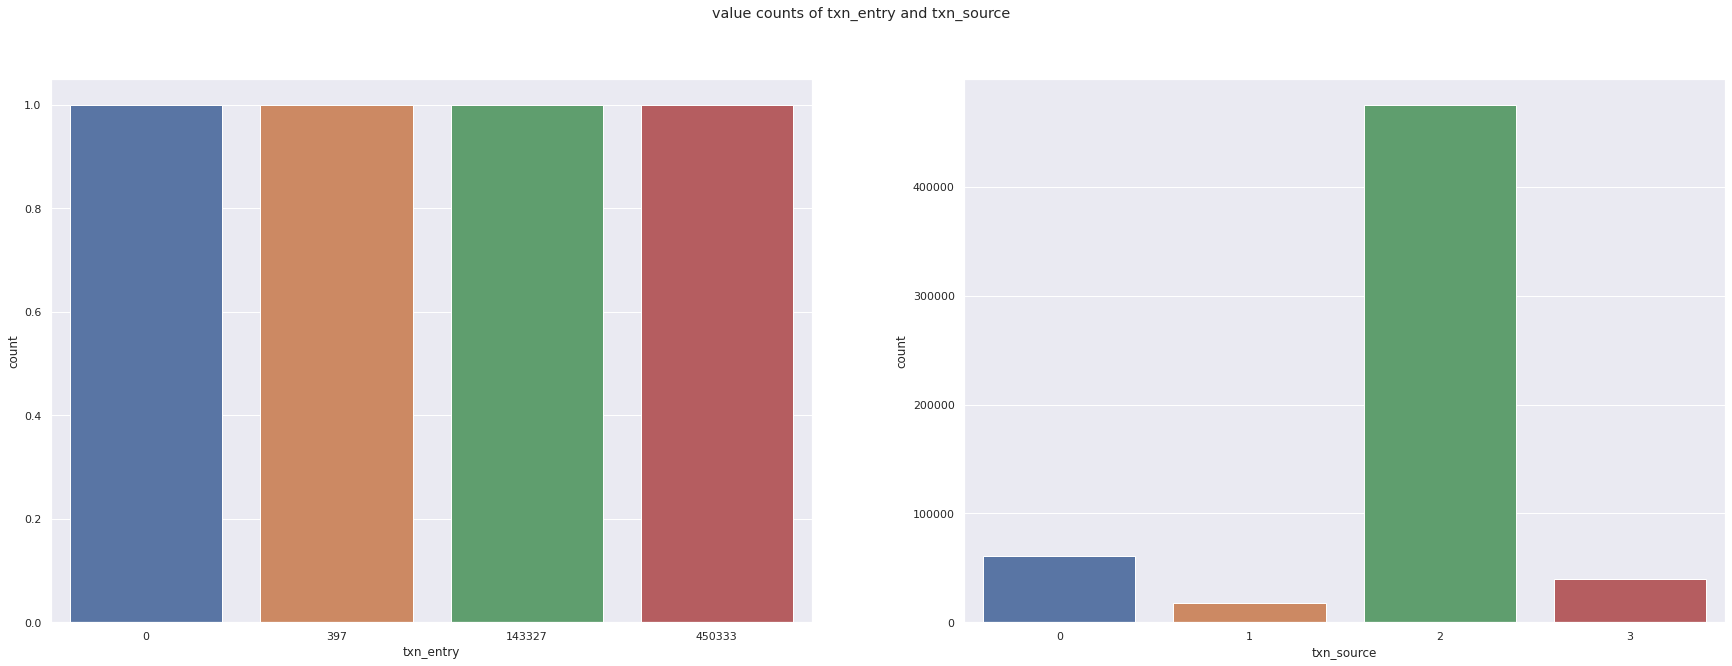

In [54]:
fig, axs = plt.subplots(1,2,figsize=(30, 10))
fig.suptitle('value counts of txn_entry and txn_source')
sns.countplot(df_data.txn_entry.value_counts(),ax=axs[0]);
sns.countplot(df_data.txn_source,ax=axs[1]);

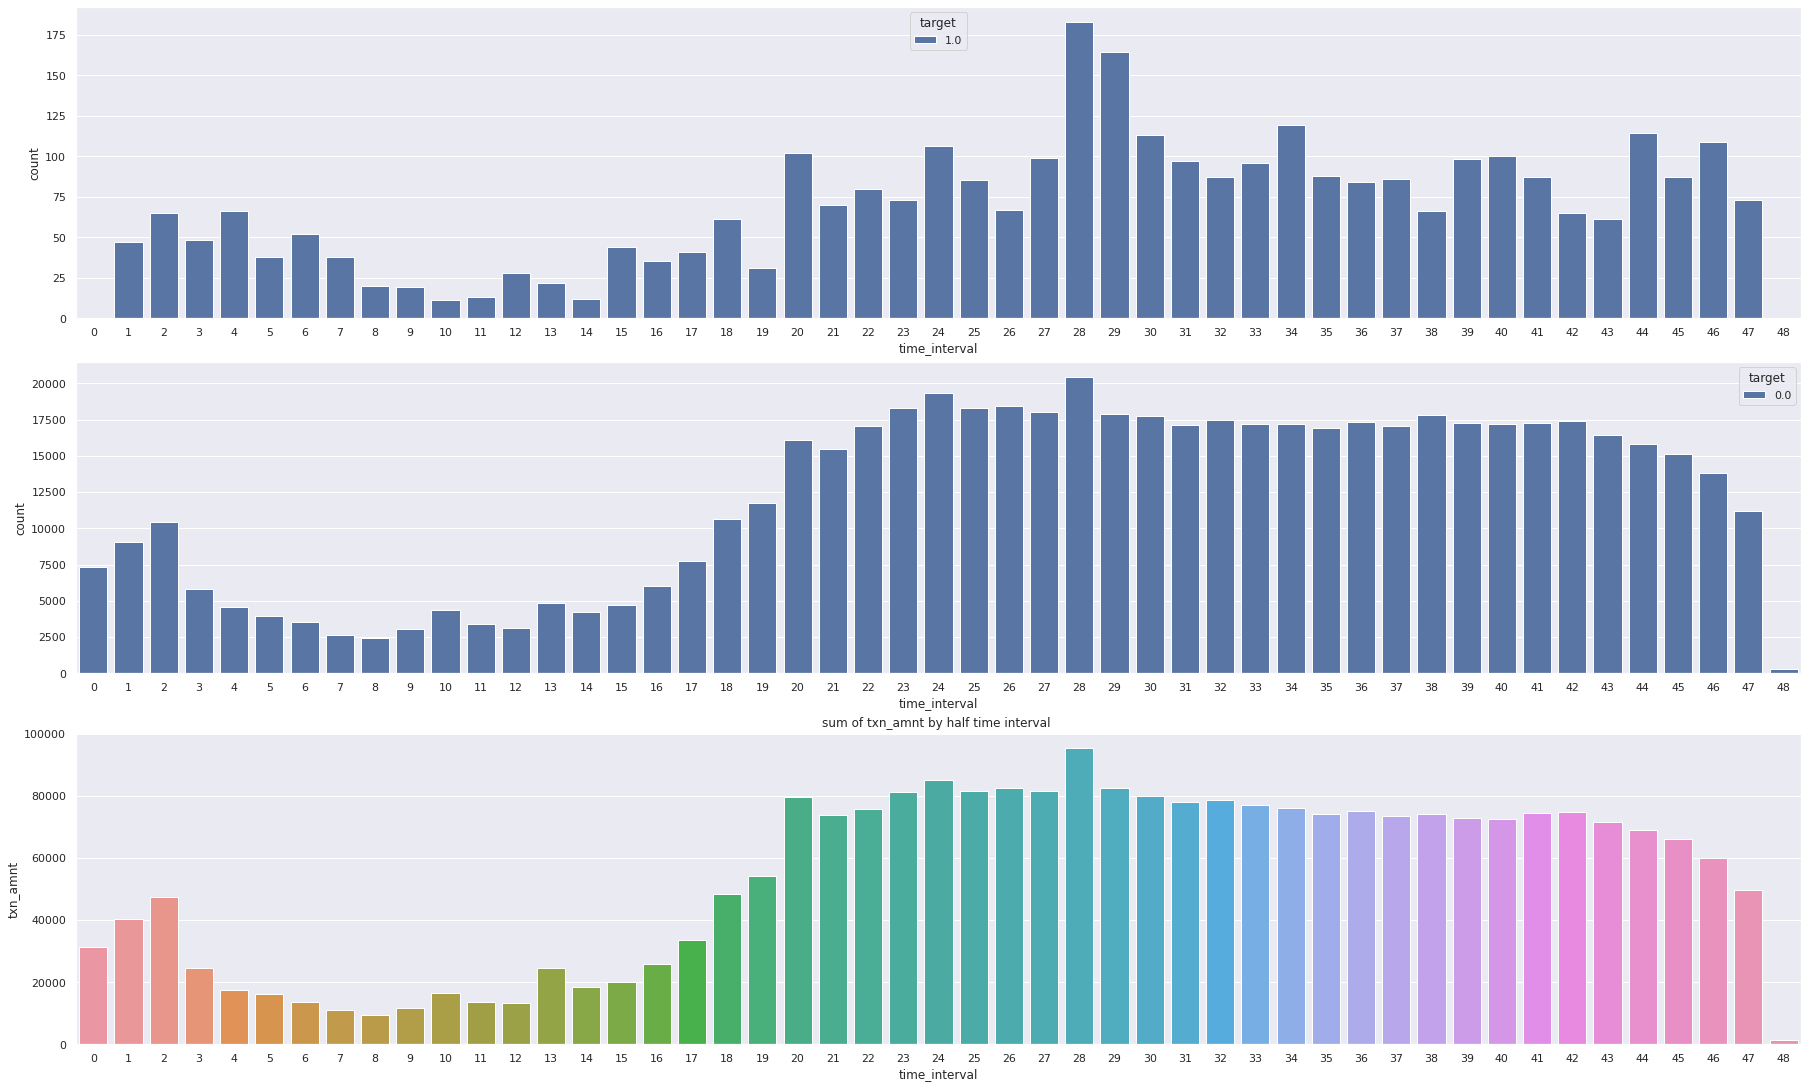

In [55]:
fig,ax=plt.subplots(3,1,figsize=(25,15),constrained_layout = True)
sns.countplot(x='time_interval',hue='target',data=df_data[df_data.target==1],ax=ax[0]);
sns.countplot(x='time_interval',hue='target',data=df_data[df_data.target==0],ax=ax[1]);
sns.barplot(x='time_interval',y='txn_amnt',data=df_data.groupby('time_interval').txn_amnt.sum().reset_index(),ax=ax[2]).set(title='sum of txn_amnt by half time interval ');

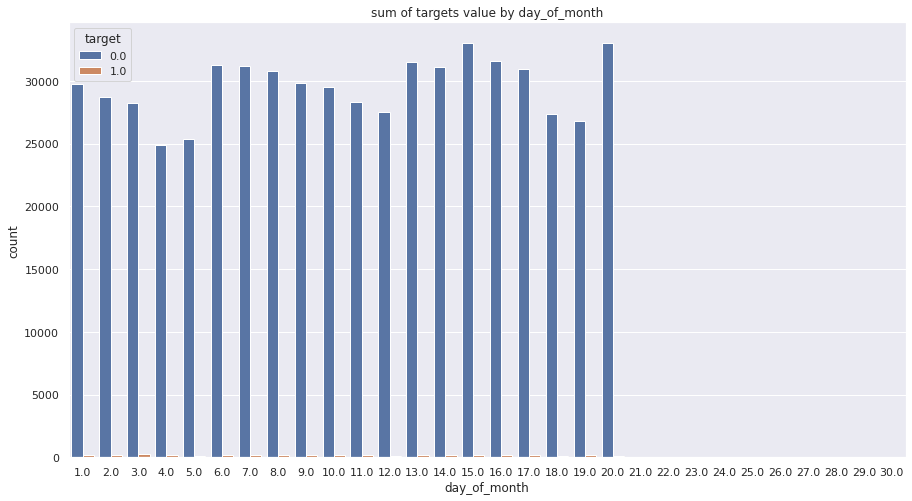

In [56]:
##As we see, some days of the month's target values are zero. That means test data only contain data after the 21st of the month 
sns.set(rc={'figure.figsize':(15,8)});
sns.countplot(x='day_of_month',hue='target',data=df_data).set_title('sum of targets value by day_of_month');

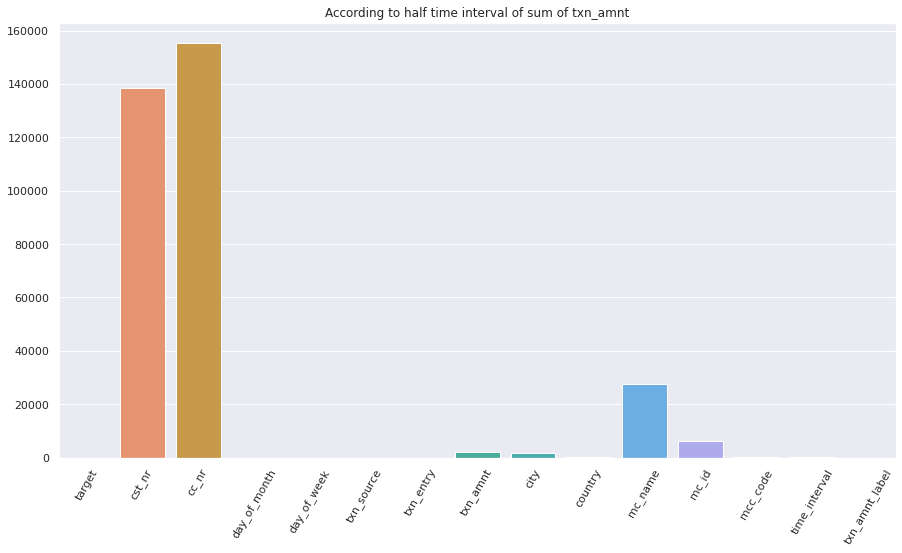

In [57]:
g=sns.barplot(x=df_data.nunique().index,y=df_data.nunique().values);
g.set(title='According to half time interval of sum of txn_amnt');
g.set_xticklabels(g.get_xticklabels(),rotation=60);

In [58]:
neg, pos = np.bincount(df_data['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 594057
    Positive: 3350 (0.56% of total)



> **Created train ana valid data**

In [59]:
train_data,valid_data,train_y,valid_y=train_test_split(df_data.drop('target',axis=1),df_data.target.astype(float),test_size=0.20,stratify=df_data.target.astype(float))
print(f'train_data shape :',train_data.shape)
print(f'valid_data shape :',valid_data.shape)

train_data shape : (475245, 14)
valid_data shape : (118812, 14)


> **In here,I reduce some categorical variable objects count because object frequencies have very few.
I assigned the tag "unknown"**

> **for Train,Valid and Test data**

In [60]:
# train_data,valid_data,df_test=decline_object(['city', 'country', 'mc_name', 'mc_id','mcc_code'],train_data,valid_data,df_test,0.2)

## Feature Engineering

In [61]:
train_data['target']=train_y.values
dum=train_data.groupby('txn_source').agg({'target':['sum','mean']}).rename(columns={'sum':'txn_source_target_sum','mean':'txn_source_target_mean'})  
dum=dum.reset_index()
train_data=train_data.merge(dum,how='left',on='txn_source')
valid_data=valid_data.merge(dum,how='left',on='txn_source')
df_test=df_test.merge(dum,how='left',on='txn_source')

dum=train_data.groupby(['txn_source','txn_amnt_label']).agg({'target':['sum','mean']}).rename(columns={'sum':'feature_sum1','mean':'feature_mean1'})  
dum=dum.reset_index()
train_data=train_data.merge(dum,how='left',on=['txn_source','txn_amnt_label'])
valid_data=valid_data.merge(dum,how='left',on=['txn_source','txn_amnt_label'])
df_test=df_test.merge(dum,how='left',on=['txn_source','txn_amnt_label'])

dum=train_data.groupby(['txn_entry','txn_amnt_label']).agg({'target':['sum','mean']}).rename(columns={'sum':'feature_sum2','mean':'feature_mean2'})  
dum=dum.reset_index()
train_data=train_data.merge(dum,how='left',on=['txn_entry','txn_amnt_label'])
valid_data=valid_data.merge(dum,how='left',on=['txn_entry','txn_amnt_label'])
df_test=df_test.merge(dum,how='left',on=['txn_entry','txn_amnt_label'])

dum=train_data.groupby(['day_of_month','txn_amnt_label']).agg({'target':['sum','mean']}).rename(columns={'sum':'feature_sum3','mean':'feature_mean3'})  
dum=dum.reset_index()
train_data=train_data.merge(dum,how='left',on=['day_of_month','txn_amnt_label'])
valid_data=valid_data.merge(dum,how='left',on=['day_of_month','txn_amnt_label'])
df_test=df_test.merge(dum,how='left',on=['day_of_month','txn_amnt_label'])

train_data.drop('target',axis=1,inplace=True)

In [62]:
valid_data['target']=valid_y.values
valid_data=pd.concat([valid_data[valid_data.target==0].sample(20000,random_state=20),valid_data[valid_data.target==1]])
valid_y=valid_data['target']
valid_data.drop('target',axis=1,inplace=True)

In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475245 entries, 0 to 475244
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   cst_nr                            475245 non-null  category
 1   cc_nr                             475245 non-null  category
 2   day_of_month                      475245 non-null  category
 3   day_of_week                       475245 non-null  category
 4   txn_source                        475245 non-null  category
 5   txn_entry                         475245 non-null  category
 6   txn_amnt                          475245 non-null  float64 
 7   city                              475245 non-null  category
 8   country                           475245 non-null  category
 9   mc_name                           475245 non-null  category
 10  mc_id                             475245 non-null  category
 11  mcc_code                          47524

In [64]:
valid_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20670 entries, 60389 to 118789
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   cst_nr                            20670 non-null  category
 1   cc_nr                             20670 non-null  category
 2   day_of_month                      20670 non-null  category
 3   day_of_week                       20670 non-null  category
 4   txn_source                        20670 non-null  category
 5   txn_entry                         20670 non-null  category
 6   txn_amnt                          20670 non-null  float64 
 7   city                              20670 non-null  category
 8   country                           20670 non-null  category
 9   mc_name                           20670 non-null  category
 10  mc_id                             20670 non-null  category
 11  mcc_code                          20670 non-null 

In [65]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326232 entries, 0 to 326231
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   cst_nr                            326232 non-null  category
 1   cc_nr                             326232 non-null  category
 2   day_of_month                      326232 non-null  category
 3   day_of_week                       326232 non-null  category
 4   txn_source                        326232 non-null  category
 5   txn_entry                         326232 non-null  category
 6   txn_amnt                          326232 non-null  float64 
 7   city                              326232 non-null  category
 8   country                           326232 non-null  category
 9   mc_name                           326232 non-null  category
 10  mc_id                             326232 non-null  category
 11  mcc_code                          32623

## XGBOOST model and OPTUNA

> **I have used the Xgboost algorithm for the train-to-model. Then ı have tuned the model  with 'optuna' to select the best params according to f1 Score**

In [32]:
def objective(trial,data=train_data,target=train_y,X_val=valid_data,y_val=valid_y):
    
    param = {
             'use_label_encoder':True, 
             'eval_metric':'logloss',
             "objective": "binary:logistic",
             'tree_method':'gpu_hist',
             'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
             'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.1,0.2]),
             'n_estimators': 500,
             'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
             'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 500),
            'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.0, 100.0),
            'enable_categorical':True
    } 
  

    model = xgb.XGBClassifier(**param)  
    model.fit(data,target,eval_set=[(data, target), (X_val, y_val)],verbose=0,early_stopping_rounds=100)


    preds = model.predict_proba(X_val)[:, 1]
    preds= list(map(lambda x : 1 if x >0.5 else 0, preds))
    scores=accuracy_score(y_val,preds)
    return scores
    


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=85)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
gc.collect()

[I 2023-03-14 05:12:44,454] A new study created in memory with name: no-name-ffe7e278-dd1f-4894-beb1-c3207bbcbbd1


KeyboardInterrupt: 

In [33]:
params={
'lambda': 7.053559935260143, 'alpha': 1.6306954561880138, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 6, 'scale_pos_weight': 75.12912348183887,
    'n_estimators':500,
    
'use_label_encoder':True, 
'eval_metric':'logloss',
"objective": "binary:logistic",
'tree_method':'gpu_hist'
}

In [ ]:
# best_params=study.best_trial.params
# best_params.update({'use_label_encoder': False,
#                     'n_estimators': 500,
#                     'objective':'binary:logistic',
#                     'eval_metric':'logloss'})

# if torch.cuda.is_available()==True :
#     best_params.update({'tree_method':'gpu_hist'})
# best_params

# # Datdf_dataa tpyes are adjusted for xgboost
# cat_features=['cst_nr', 'cc_nr', 'day_of_month', 'day_of_week', 'txn_source',
#        'txn_entry', 'city', 'country', 'mc_name', 'mc_id',
#        'mcc_code',  'time_interval','txn_amnt_label']
# train_data[cat_features]=train_data[cat_features].astype('category')
# valid_data[cat_features]=valid_data[cat_features].astype('category')
# df_test[cat_features]=df_test[cat_features].astype('category')

> **All model of xgboost according to random state parameter**

In [35]:
all_models=[]
for i in [1200, 22,44]:
    params["random_state"] = i
    model = xgb.XGBClassifier(**params,enable_categorical=True)  
    train_set=[(train_data,train_y)]
    model.fit(train_data,train_y,verbose=False)
    all_models.append(model)
preds = [model.predict_proba(df_test)[:, 1] for model in all_models]
xgboost_mean_preds = np.mean(preds, axis=0)
pred=(np.where(xgboost_mean_preds > 0.5, 1, 0))
print(pred.sum())


2123


<AxesSubplot:>

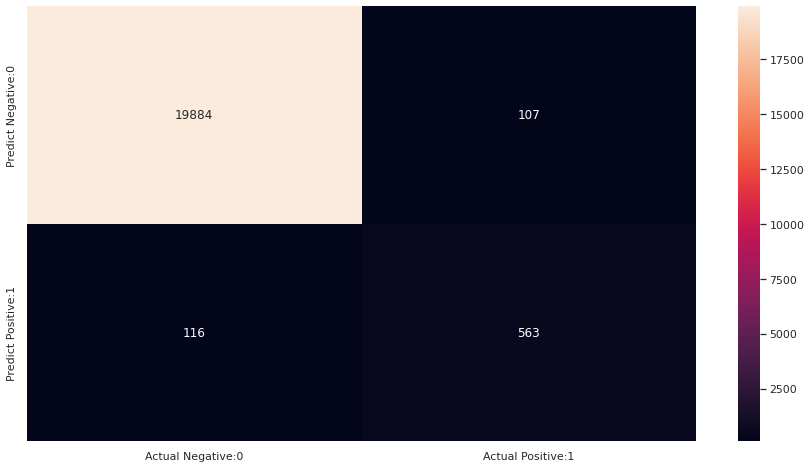

In [36]:
cm = confusion_matrix(model.predict(valid_data),valid_y.astype('int'))
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                 index=[ 'Predict Negative:0','Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d')

> **Feature İmportance**

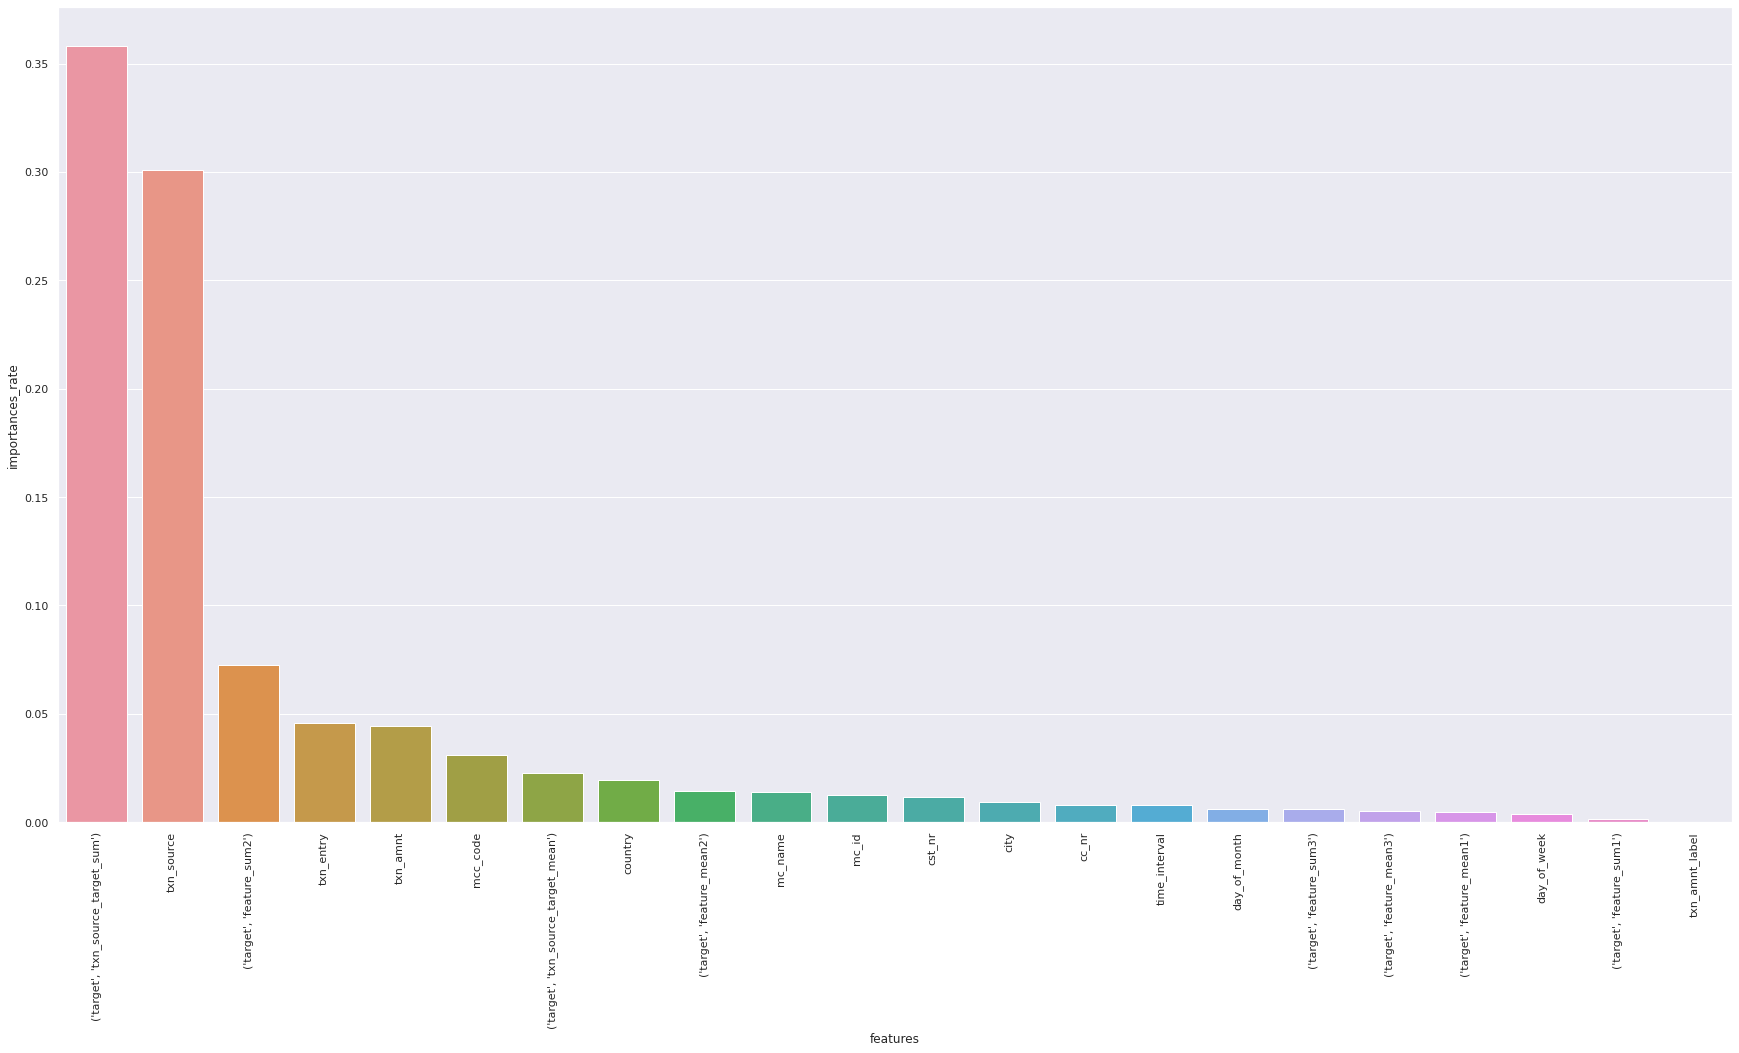

In [37]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':df_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
submission=pd.read_csv('/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/sample_submission.csv')
submission['Predicted']=xgboost_mean_preds
submission.iloc[:,:2].set_index('Id').to_csv('/kaggle/working/result120.csv')

## CATBOOST MODEL AND OPTUNA

> **I have used the other algorithm Catboost  for the train-to-model. Then ı have tuned the model  with 'optuna' to select the best params according to f1 Score**

In [67]:
# Data tpyes are adjusted for catboost
cat_features=['cst_nr', 'cc_nr', 'day_of_month', 'day_of_week', 'txn_source',
       'txn_entry', 'city', 'country', 'mc_name', 'mc_id',
       'mcc_code',  'time_interval','txn_amnt_label']
train_data[cat_features]=train_data[cat_features].astype(str)
valid_data[cat_features]=valid_data[cat_features].astype(str)
df_test[cat_features]=df_test[cat_features].astype(str)

In [68]:

from catboost import CatBoostClassifier

def objective(trial,data=train_data,target=train_y,X_val=valid_data,y_val=valid_y):

    catboost_params = {"subsample": trial.suggest_float("subsample", 0.5, 0.99),
                        'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                        "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
                        "max_depth": trial.suggest_int("max_depth", 4, 10, step=1),
                        "n_estimators": 300,
                        'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                      }


    mcat = CatBoostClassifier(**catboost_params)
    mcat.fit(data, target,
            use_best_model = True,
            early_stopping_rounds = 50,
             verbose=0,
              eval_set=(X_val, y_val),
            cat_features=cat_features
            )
    preds = mcat.predict(X_val)
    score = accuracy_score(valid_y, preds)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=85)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-03-14 06:51:10,166] A new study created in memory with name: no-name-6a8f4408-366b-4ca2-9c16-8bc42f5d640e
[I 2023-03-14 07:01:17,655] Trial 0 finished with value: 0.9902273826802128 and parameters: {'subsample': 0.8032334402587269, 'od_wait': 14, 'colsample_bylevel': 0.5447363539411377, 'random_strength': 6, 'l2_leaf_reg': 3.9120656727982004, 'max_depth': 9, 'learning_rate': 0.024896456302524177}. Best is trial 0 with value: 0.9902273826802128.


KeyboardInterrupt: 

In [70]:
cat_best_params={
'subsample': 0.8032334402587269, 'od_wait': 14, 'colsample_bylevel': 0.5447363539411377, 'random_strength': 6, 'l2_leaf_reg': 3.9120656727982004, 'max_depth': 9, 'learning_rate': 0.024896456302524177,
    "n_estimators": 300}



all_models = []
for i in [234,42]:
    cat_best_params["random_state"] = i
    cat_model =  CatBoostClassifier(**cat_best_params)
    cat_model_trained = cat_model.fit(train_data,train_y,verbose=0,cat_features=cat_features)
    all_models.append(cat_model_trained)

cat_preds = [cat_model_trained.predict_proba(df_test)[:, 1] for model in all_models]
catboost_mean_preds = np.mean(cat_preds, axis=0)
print(np.sum(np.where(catboost_mean_preds>0.5,1,0)))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

424


<AxesSubplot:>

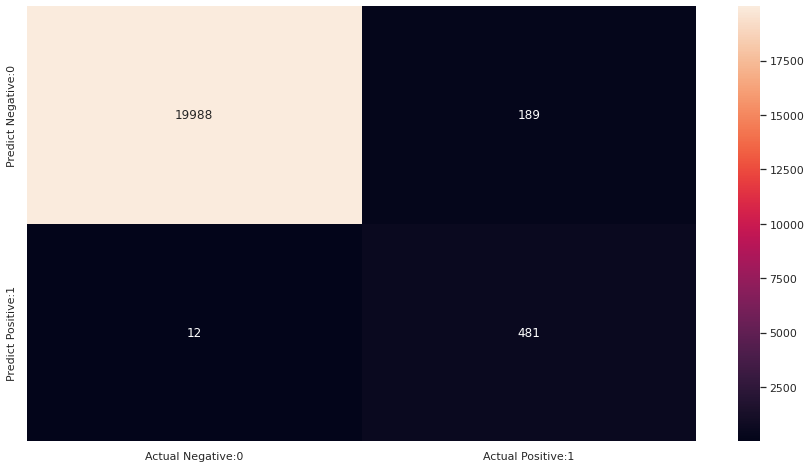

In [71]:
cm = confusion_matrix(cat_model_trained.predict(valid_data),valid_y.astype('int'))
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                 index=[ 'Predict Negative:0','Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d')

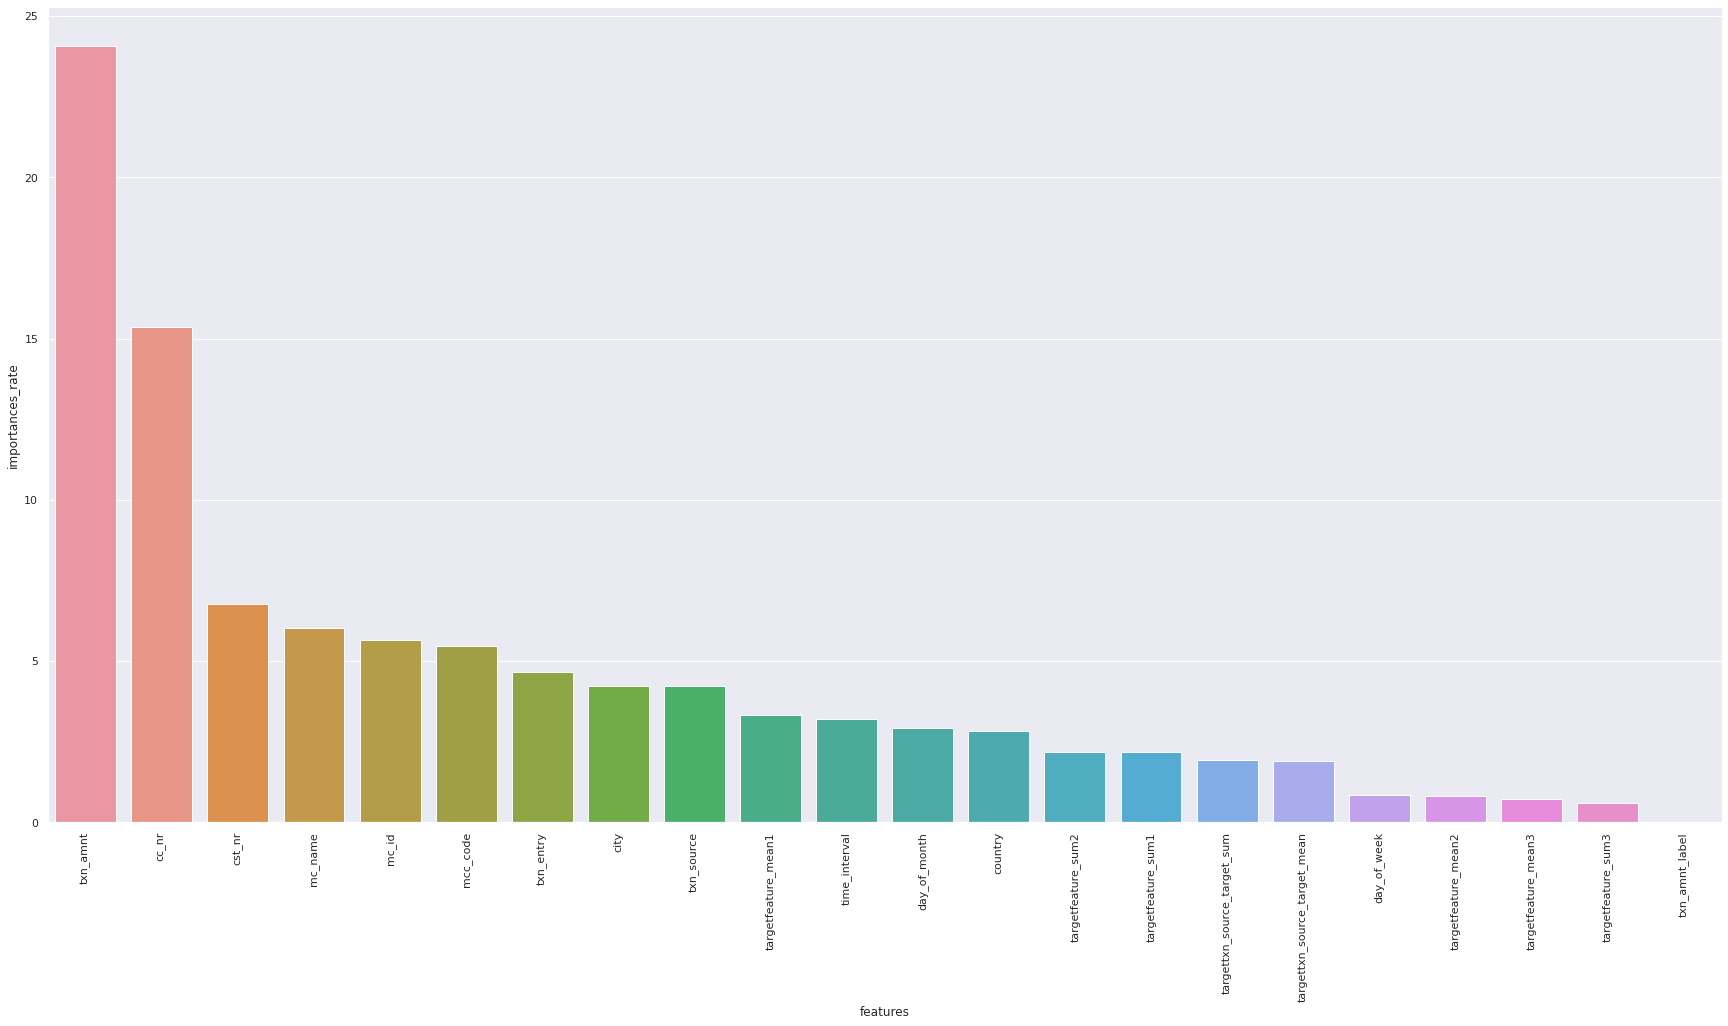

In [72]:
importances=pd.DataFrame([cat_model_trained.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':df_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
dum.features=[s[0]+s[1] if isinstance(s,tuple) else s for s in dum.features]
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [73]:
submission=pd.read_csv('/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/sample_submission.csv')
submission['Predicted']=catboost_mean_preds
submission.iloc[:,:2].set_index('Id').to_csv('/kaggle/working/result120.csv')
submission

,Id,Predicted
0,0,0.008997
1,1,0.000885
2,2,0.009552
3,3,0.007947
4,4,0.007882
...,...,...
326227,326227,0.000666
326228,326228,0.000417
326229,326229,0.000672
326230,326230,0.001846


> **Embedded Xgboost and CatBoost results**

In [1]:
xgboost_catboost_pred_mean=(catboost_mean_preds+xgboost_mean_preds)/2
xgboost_catboost_pred_mean

NameError: name 'catboost_mean_preds' is not defined

In [ ]:
submission=pd.read_csv('/kaggle/input/turkiye-is-bankasi-machine-learning-challenge-4/MLChallenge4/sample_submission.csv')
submission['Predicted']=xgboost_catboost_pred_mean
submission.iloc[:,:2].set_index('Id').to_csv('/kaggle/working/resultxgboost_catboost_pred_mean1.csv')
submission